# Gabor Activation

In [1]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../..')

import libtools

---

### FILTERS

In [3]:
def gabor_filter(sigma_x, sigma_y, deg, samples=20, k=2, min=-5, max=5):
    gradient = np.linspace(min, max, samples)
    X, Y = np.meshgrid(gradient, gradient)

    rad = np.deg2rad(deg)
    X = X * np.cos(rad) - Y * np.sin(rad)
    Y = X * np.sin(rad) + Y * np.cos(rad)

    C = 1 / (2 * np.pi * sigma_x * sigma_y)
    z = C * np.exp(-(X**2) / (2 * sigma_x**2) - (Y**2) / (2 * sigma_y**2))
    gabor = np.cos(X * k) * z
    return gabor

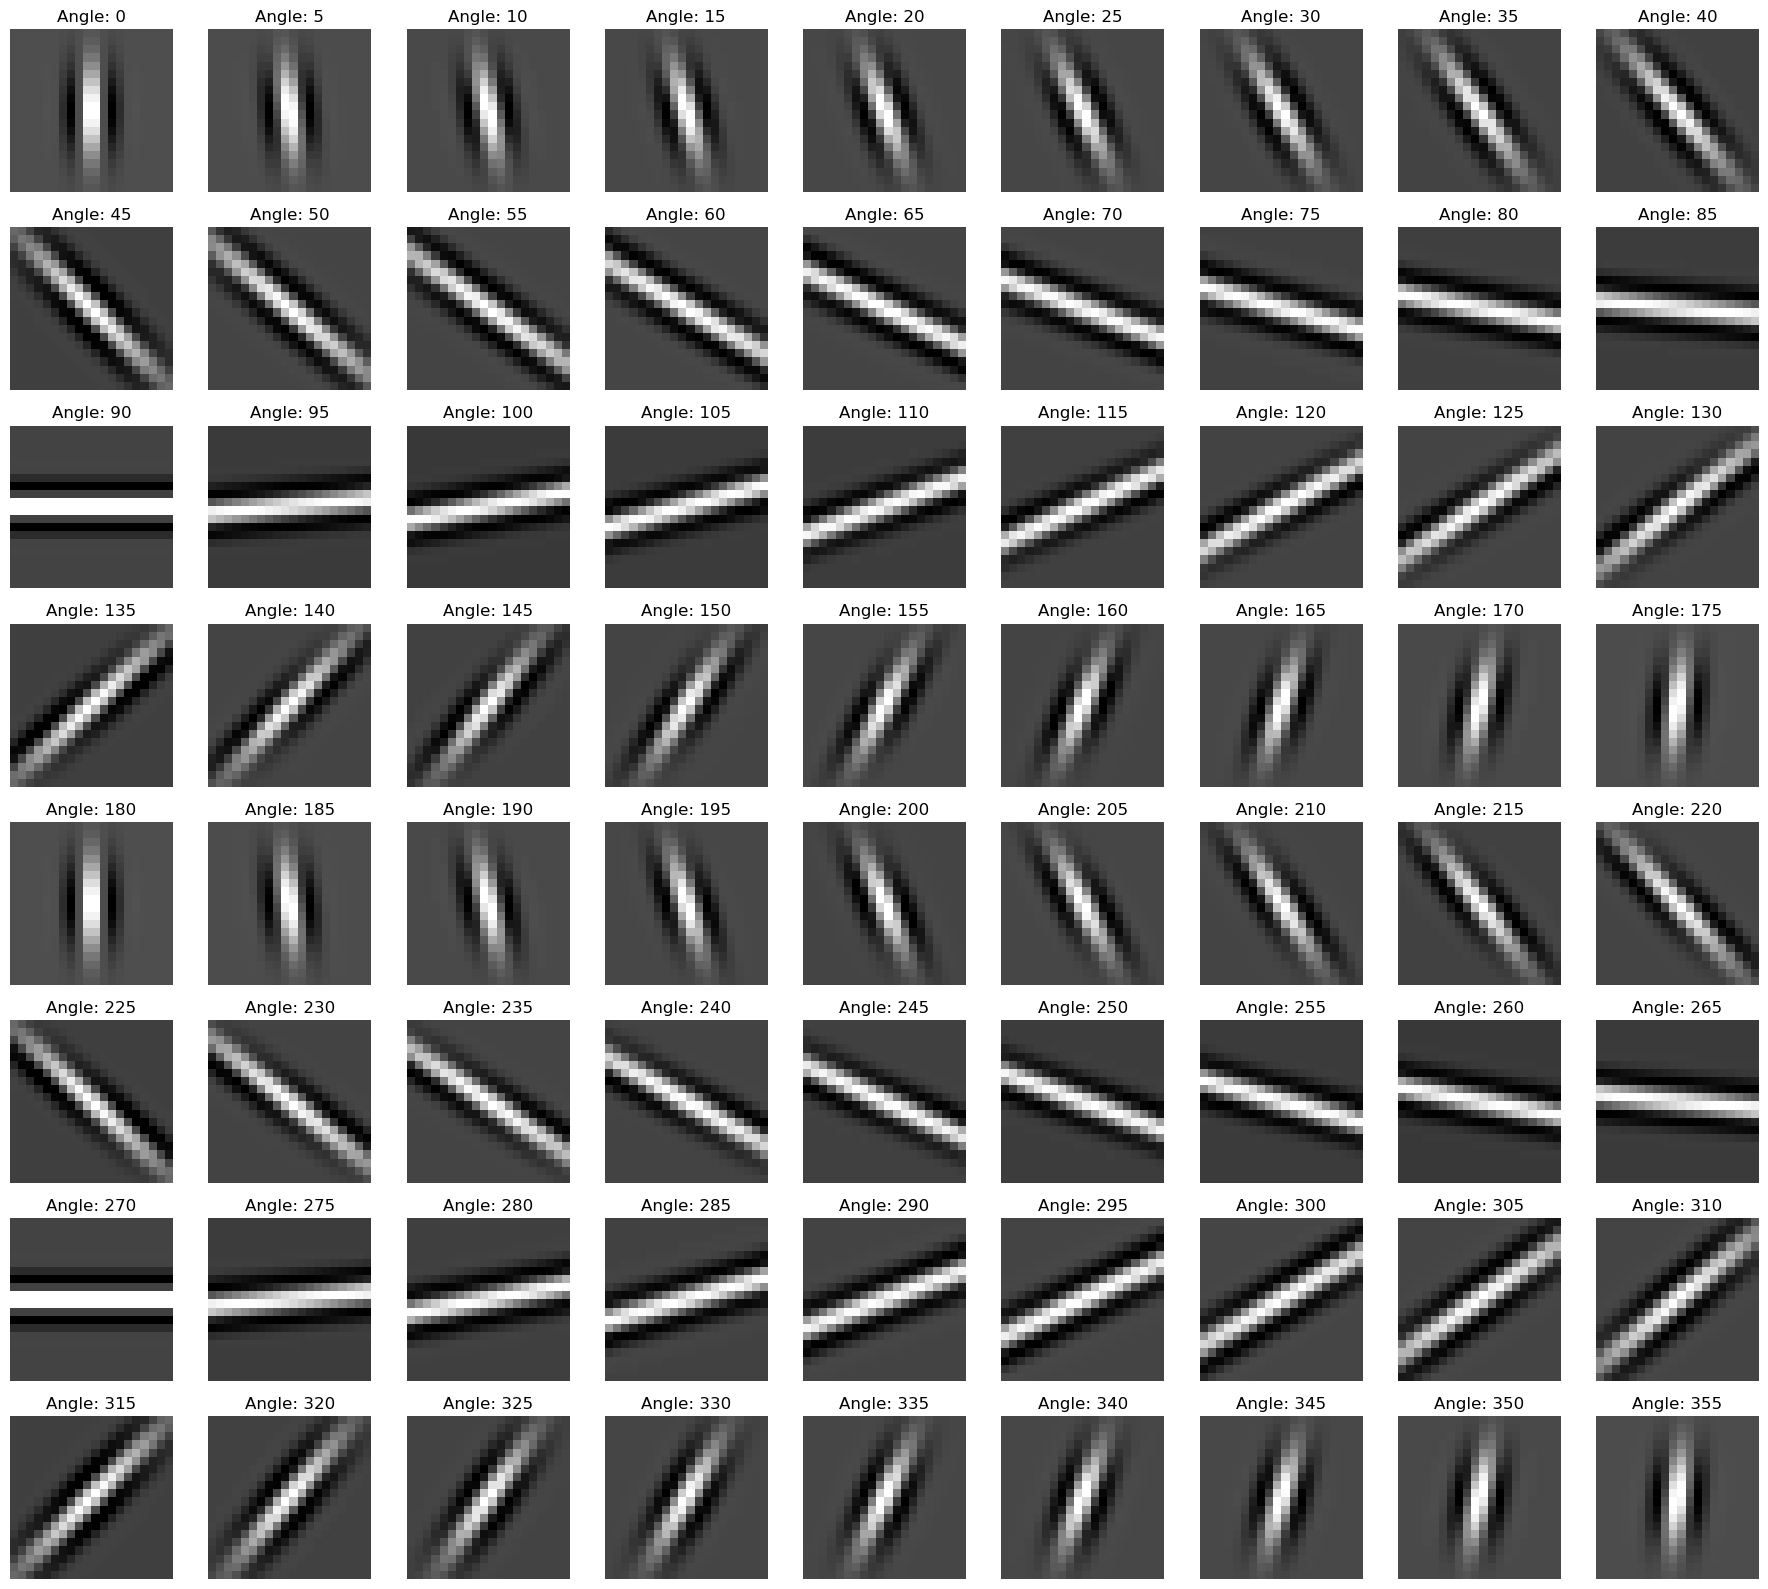

In [4]:
n = 72
row = 8
col = int(n/row)
step = int(360/n)

sigma_x = 1
sigma_y = 2

plt.figure(figsize=(18,16))
for i in range(n):
    kernel = libtools.gabor_filter(sigma_x, sigma_y, i*step)
    plt.subplot(row,col,i+1)
    plt.imshow(kernel, cmap='gray')
    plt.title('Angle: ' + str(i*step))
    plt.axis('off')

plt.tight_layout()

---

### ACTIVATIONS

In [5]:
img = PIL.Image.open("../../data/images/coco/mesh.png").convert('L')
img /= np.max(img)

In [6]:
f = np.fft.fft2(img) # Frequency transform
fshift = np.fft.fftshift(f) # Shift zero frequency component (DC-component)
power = np.abs(fshift) # Process complex numbers
phase = np.angle(fshift)

In [7]:
# Define radial distance
nx, ny = power.shape
x = np.arange(-power.shape[0]//2, power.shape[0]//2)
y = np.arange(-power.shape[1]//2, power.shape[1]//2)
X, Y = np.meshgrid(x, y)
dist = np.sqrt(X**2 + Y**2)

# Compute spatial frequency
hist, bins = np.histogram(dist.flatten(), bins=np.arange(dist.max()), weights=power.flatten())

count = hist[1:].argmax()
print('Freqency at which power is greatest:', count)

Freqency at which power is greatest: 14


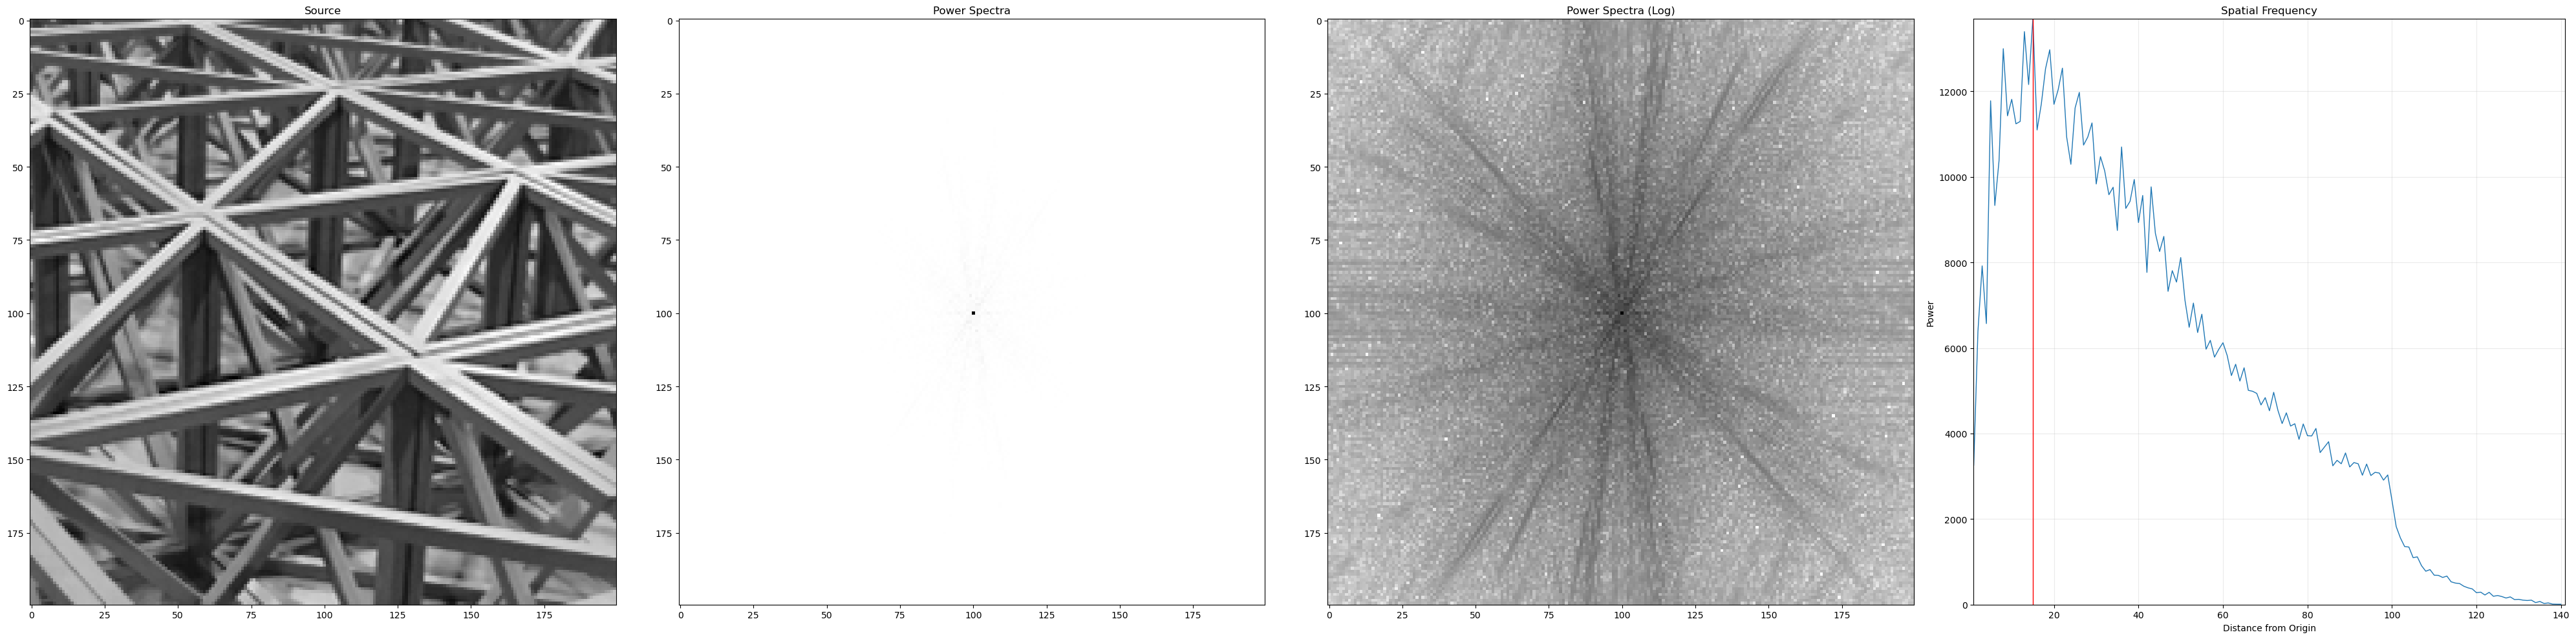

In [8]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(img, 'gray')
plt.title('Source')

plt.subplot(1,4,2)
plt.imshow(power, 'binary')
plt.title('Power Spectra')

plt.subplot(1,4,3)
plt.imshow(np.log(power), 'binary')
plt.title('Power Spectra (Log)')

plt.subplot(1,4,4)
plt.plot(bins[:-1], hist, lw=1)
plt.vlines(count+1, 0, hist[1:].max(), linewidth=1, color='r')
plt.title('Spatial Frequency')
plt.xlabel('Distance from Origin'), plt.ylabel('Power')
plt.xlim([1,int(dist.max())]), plt.ylim([0,int(hist[1:].max())])
plt.grid(alpha=0.25)
plt.tight_layout()

In [9]:
step = int(count)
kernel = gabor_filter(sigma_x, sigma_y, 0, step)

pad = int(np.ceil(step/2))
pad_im = np.pad(img, pad, mode='constant', constant_values=0)

[pad_h, pad_w] = pad_im.shape
features = np.zeros_like(pad_im)

for i in range(1,pad_w-step):
    for j in range(1, pad_h-step):
        patch = pad_im[j:j+step,i:i+step]
        conv = patch * kernel
        rate = np.sum(conv)
        if rate <= 0:
            rate = 0
        features[int(j+(step/2)),int(i+(step/2))] = rate

features = features[pad:pad+img.shape[0],pad:pad+img.shape[1]]
features[features<=0] = 0 # Rectify
features /= np.max(features)

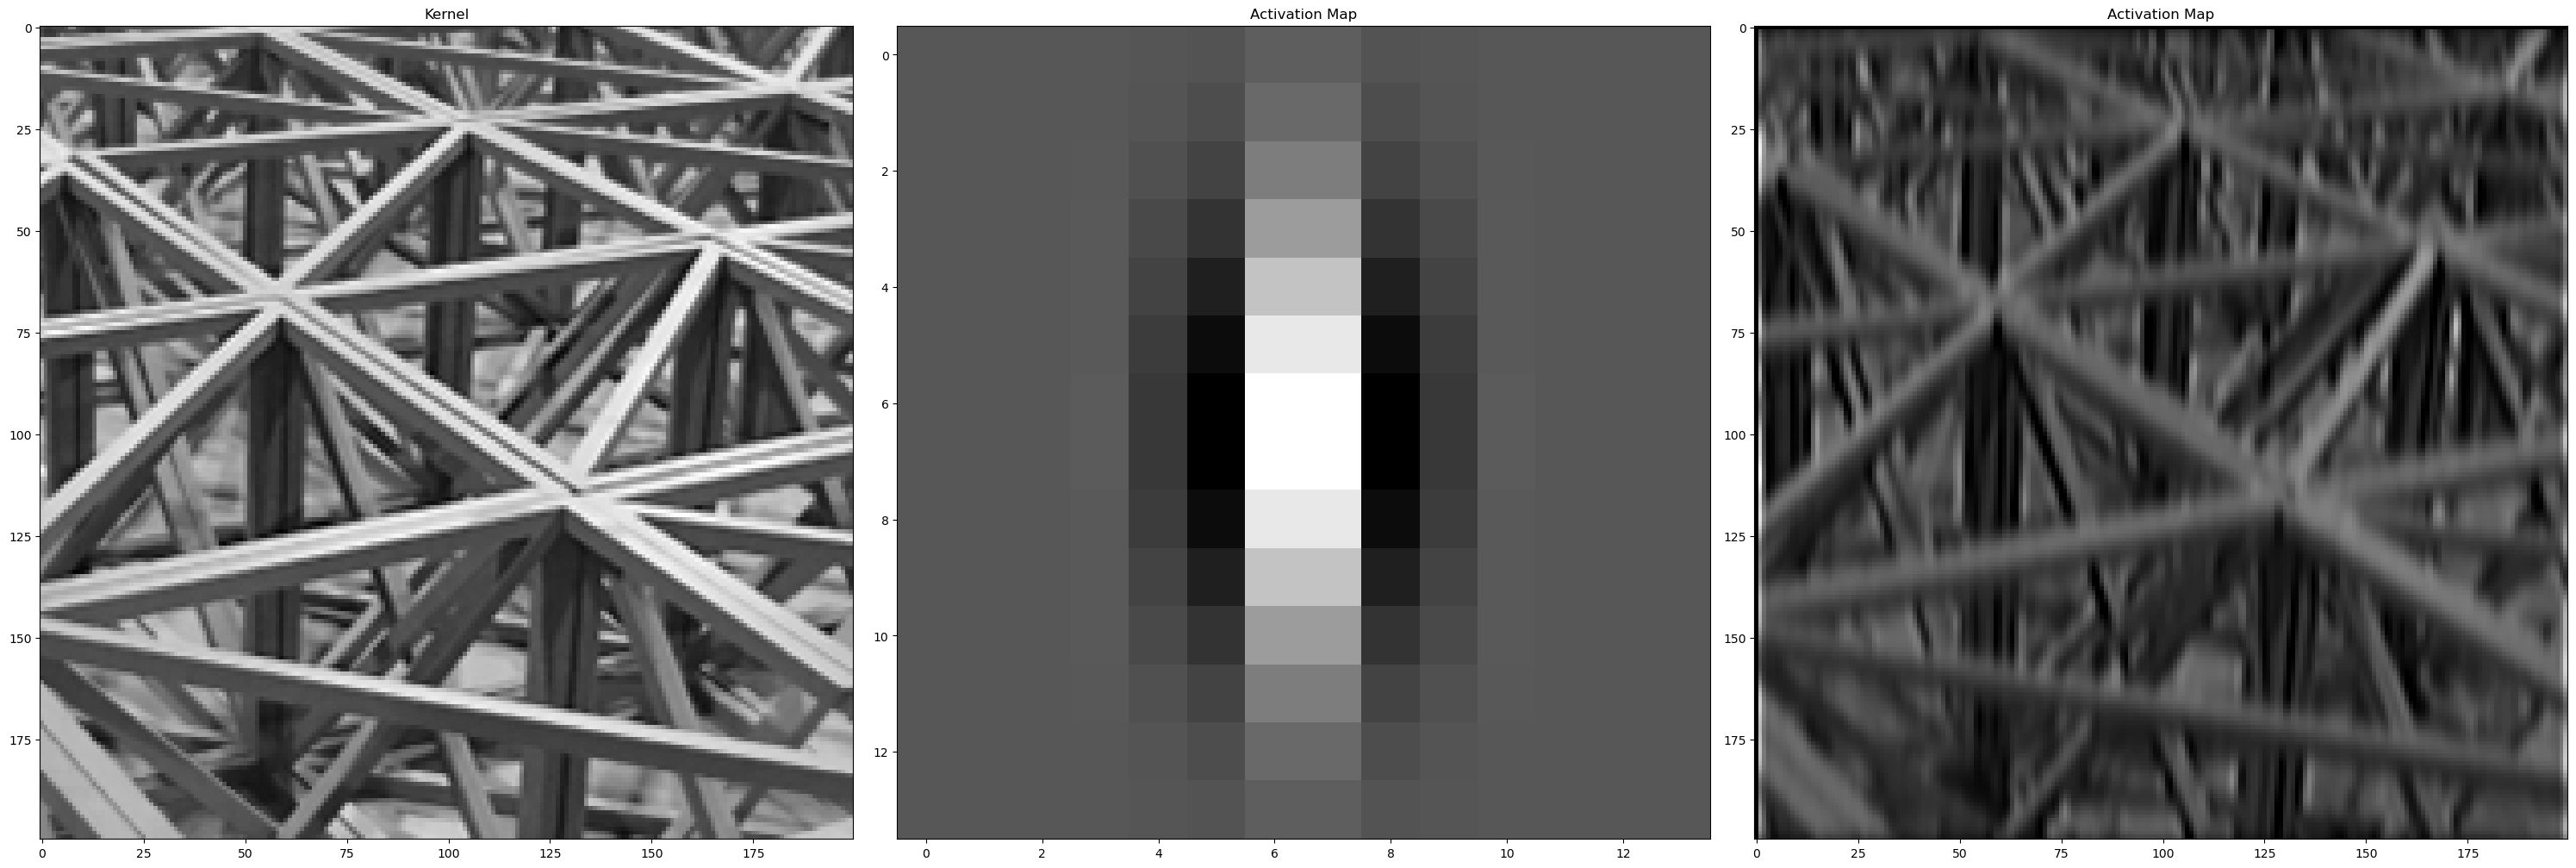

In [10]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(img, 'gray')
plt.title('Kernel')

plt.subplot(1,3,2)
plt.imshow(kernel, 'gray')
plt.title('Activation Map')

plt.subplot(1,3,3)
plt.imshow(features, 'gray')
plt.title('Activation Map')
plt.tight_layout()